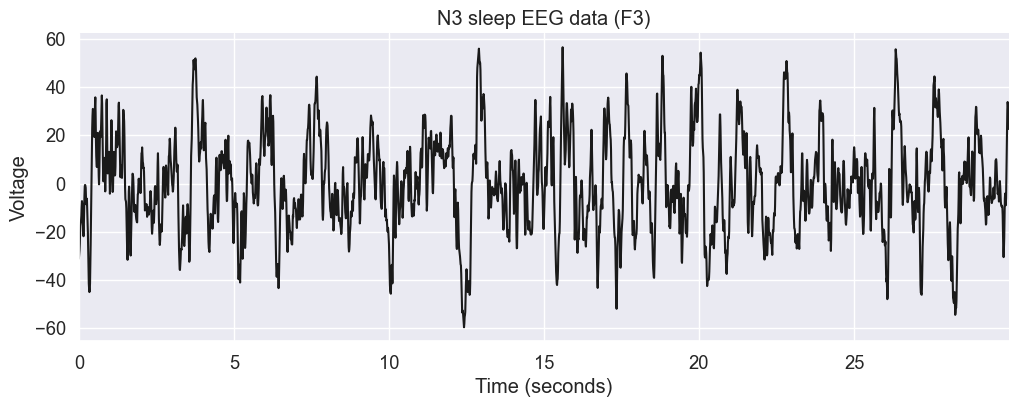

In [6]:
import pandas as pd
import numpy as np

# Paths
in_path = "/Users/stageacomeback/Desktop/EEG Raw Data.csv"

# Load data
data = pd.read_csv(in_path, header=None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 100.
time = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()

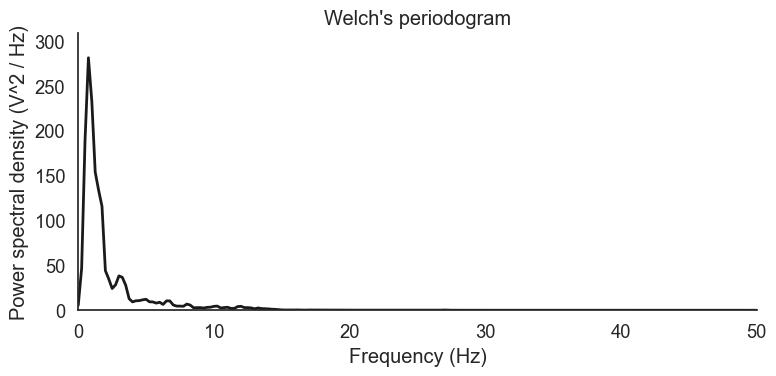

In [7]:
from scipy import signal

# Ensure the EEG is a 1D float array (pick first column if the CSV has multiple)
eeg = np.asarray(data.iloc[:, 0] if isinstance(data, pd.DataFrame) else data, dtype=np.float64).ravel()

# Define window length (4 seconds) in samples (must be int and <= len signal)
win = int(4 * sf)
win = min(win, eeg.size) if eeg.size > 0 else 256  # fallback to something reasonable

# Compute Welch PSD with explicit parameters for stability across versions
freqs, psd = signal.welch(
    eeg,
    fs=sf,
    window="hann",
    nperseg=win,
    noverlap=win // 2,
    detrend="constant",
    scaling="density",
    average="mean"
)

# Plot PSD
sns.set_theme(context="notebook", style="white", font_scale=1.2)
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title("Welch's periodogram")
plt.xlim([0, float(freqs.max()) if freqs.size else 0.0])
if psd.size and np.isfinite(psd.max()):
    plt.ylim([0, float(psd.max()) * 1.1])
sns.despine()
plt.tight_layout()
plt.show()

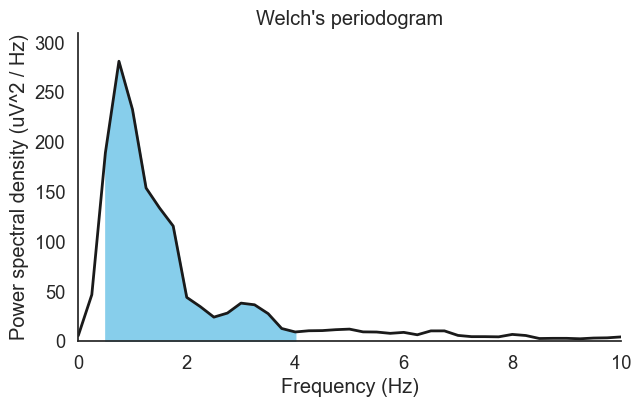

In [8]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [10]:
from scipy.integrate import simpson

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simpson(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 321.064 uV^2


In [11]:
# Relative delta power (expressed as a percentage of total power)
total_power = simpson(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.787
